In [22]:
library(tidyverse)
library(cowplot)

# NORM methods contains bugs!

# Load and Filter

In [4]:
metadata <- read.table("/home/yuliya/repos/cosybio/FedProt/data/TMT_data/raw_MaxQuant_reports/Metadata_CosyBio.tsv",
                       header = TRUE, sep = "\t", stringsAsFactors = FALSE)
                       
metadata <- metadata %>%
            mutate(Quantitative.column.name = gsub(" ", ".", Quantitative.column.name))

rownames(metadata) <- metadata$Quantitative.column.name
metadata <- metadata %>%
            mutate(Quantitative.column.name = gsub(".Pool", ".P_", gsub("Reporter.intensity.corrected.", "RIC_", Quantitative.column.name)))


# remove the outlier
metadata <- metadata %>%
            filter(Quantitative.column.name != "RIC_3.P_3")


# rename the columns - put the .P_[1-9]+ after dot before and the rest after (e.g. RIC_1.P_1 -> P_1.RIC_1)
metadata <- metadata %>%
            mutate(Quantitative.column.name = gsub("RIC_([0-9]+).P_([0-9]+)", "P_\\2.RIC_\\1", Quantitative.column.name))



head(metadata, 3)
dim(metadata)

,Quantitative.column.name,Pool,Reporter.ion,Patient,Group,Center
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Reporter.intensity.corrected.1.Pool1,P_1.RIC_1,Pool1,126,Common Reference,Common Reference,Center1
Reporter.intensity.corrected.2.Pool1,P_1.RIC_2,Pool1,127N,heathy1,heathy,Center1
Reporter.intensity.corrected.3.Pool1,P_1.RIC_3,Pool1,127C,FSGS1,FSGS,Center1


[1] 65  6

In [5]:
PG_report <- read.table(
    "/home/yuliya/repos/cosybio/FedProt/data/TMT_data/raw_MaxQuant_reports/proteinGroups_combined.txt",
    header=T,
    sep="\t",
    stringsAsFactors = F)

dim(PG_report)

[1] 768 288

In [6]:
# remove decoy matches and matches to contaminant
PG_report <- PG_report[!PG_report$Reverse=="+",]
PG_report <- PG_report[!PG_report$Potential.contaminant=="+",]
# # Only.identified.by.site - exclude proteins that were only identified by a modification site
PG_report <- PG_report[!PG_report$Only.identified.by.site=="+",]


dim(PG_report)

[1] 666 288

#### intensities

In [7]:
# take only the columns that we need
pg_intensities <- PG_report %>%
    select(c("Protein.IDs", rownames(metadata))) 
rownames(pg_intensities) <- pg_intensities$Protein.IDs
pg_intensities$Protein.IDs <- NULL

colnames(pg_intensities) <- metadata$Quantitative.column.name
dim(pg_intensities)


# remove rows with all values are zeros
pg_intensities <- pg_intensities[!rowSums(pg_intensities) == 0,]
dim(pg_intensities)

pg_intensities[pg_intensities==0] <- NA
# count the % of missing values
round(sum(is.na(pg_intensities)) * 100 / (dim(pg_intensities)[1] * dim(pg_intensities)[2]), 3)


[1] 666  65

[1] 660  65

[1] 22.245

In [8]:
pg_intensities %>% write.table("/home/yuliya/repos/cosybio/FedProt/data/TMT_data/balanced_data/pg_intensities_combined.tsv",
                               sep = "\t", quote = FALSE, row.names = TRUE)

rownames(metadata) <- metadata$Quantitative.column.name
metadata %>% write.table("/home/yuliya/repos/cosybio/FedProt/data/TMT_data/balanced_data/metadata_combined.tsv",
                            sep = "\t", quote = FALSE, row.names = FALSE)
    

#### counts

In [9]:
pg_counts <- PG_report %>%
    select(c("Protein.IDs", "Razor...unique.peptides")) 
rownames(pg_counts) <- pg_counts$Protein.IDs
pg_counts$Protein.IDs <- NULL

pg_counts <- pg_counts + 1

dim(pg_counts)

pg_counts %>% write.table("/home/yuliya/repos/cosybio/FedProt/data/TMT_data/balanced_data/pg_counts_combined.tsv",
                               sep = "\t", quote = FALSE, row.names = TRUE)

[1] 666   1

# EDA combined data

## plots

In [10]:
pca_plot <- function(df, batch_info, title, path) {
  pca <- prcomp(t(na.omit(df)))
  pca_df <- pca$x %>%
    as.data.frame() %>%
    rownames_to_column("Quantitative.column.name") %>% 
    left_join(batch_info,  by = "Quantitative.column.name") 
  var_expl <- pca$sdev^2 / sum(pca$sdev^2)
  names(var_expl) <- paste0("PC", 1:length(var_expl))

  pca_plot <- pca_df %>%
    ggplot(aes(PC1, PC2)) +
    geom_point(aes(col=Group, shape=Center), size=3)  +
    theme_classic() +
    labs(title = title,
         x = glue::glue("PC1 [{round(var_expl['PC1']*100, 2)}%]"),
         y = glue::glue("PC2 [{round(var_expl['PC2']*100, 2)}%]"))

   # Check if "RIC_3.P_3" exists in the pca_df dataframe
  if("RIC_3.P_3" %in% pca_df$Quantitative.column.name) {
    pca_plot <- pca_plot +
      geom_text(data = pca_df[pca_df$Quantitative.column.name == "RIC_3.P_3", ], aes(label = Quantitative.column.name), 
                vjust = 1, hjust = 0)
  }
  ggsave(path, pca_plot, width = 5, height = 5)
  return(pca_plot)
}


# boxplot
boxplot_pg <- function(protein_matrix, title, path) {
  # Reshape data into long format
  long_data <- tidyr::gather(protein_matrix, 
                             key = "file", value = "Intensity")
  # Log tranformed scale
  boxplot <- ggplot(long_data, aes(x = file, y = Intensity)) + 
    geom_boxplot() +
    stat_summary(fun = mean, geom = "point", shape = 4, size = 3, color = "red") +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)) +
    # adjust fonsize for the x-axis
    theme(axis.text.x = element_text(size = 8)) +
    labs(title = title) 

  if(path == "") {
    return(boxplot)
  } else {
      ggsave(path, boxplot)
      return(boxplot)
  }

}


heatmap_plot <- function(pg_matrix, batch_info, name, plot_name_prefix){
    cor_matrix <- cor(na.omit(pg_matrix), use = "pairwise.complete.obs")
    pheatmap::pheatmap(cor_matrix, 
                        annotation_col = select(batch_info, c(Group, Center)),
                        treeheight_row = 0, treeheight_col = 0, 
                        main = paste0(name),
                        fontsize = 8,
                        width = 8, height = 7,
                        filename = paste0(plot_name_prefix, "_heatmap.png"))
}



In [11]:
plot_three_in_one <- function(pg_matrix, metadata, name, plot_name_prefix) {

    pca <- pca_plot(pg_matrix, metadata, paste0(name, ' pca'), paste0(plot_name_prefix, '_pca.png'))
    box <- boxplot_pg(pg_matrix, paste0(name, ' boxplot'), paste0(plot_name_prefix, '_boxplot.png'))
    heatmap_plot(pg_matrix, metadata, name, plot_name_prefix)
    
    combined_plot <- plot_grid(pca, box, ncol = 1, align = "v")

    # Save the combined plot
    ggsave(paste0(plot_name_prefix, "_combined_two.png"), combined_plot, width = 8, height = 11)
}

## results

In [12]:
metadata <- metadata %>%
    mutate(Group = as.factor(Group), Center = as.factor(Center), Reporter.ion = as.factor(Reporter.ion)) %>%
    mutate(Quantitative.column.name = gsub(" ", ".", Quantitative.column.name))

In [13]:
plot_three_in_one(log2(pg_intensities + 1),
                  metadata,
                  "TMT-data, raw protein intensities, log2-transformed",
                  "/home/yuliya/repos/cosybio/FedProt/data/TMT_data/balanced_data/combined_plots/01_pg_intensities_raw_log")
                  

Saving 6.67 x 6.67 in image
Warning message:
“Removed 9543 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 9543 rows containing non-finite values (`stat_summary()`).”
Warning message:
“Removed 9543 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 9543 rows containing non-finite values (`stat_summary()`).”
Warning message:
“Graphs cannot be vertically aligned unless the axis parameter is set. Placing graphs unaligned.”


In [14]:
head(metadata)

,Quantitative.column.name,Pool,Reporter.ion,Patient,Group,Center
,<chr>,<chr>,<fct>,<chr>,<fct>,<fct>
P_1.RIC_1,P_1.RIC_1,Pool1,126,Common Reference,Common Reference,Center1
P_1.RIC_2,P_1.RIC_2,Pool1,127N,heathy1,heathy,Center1
P_1.RIC_3,P_1.RIC_3,Pool1,127C,FSGS1,FSGS,Center1
P_1.RIC_4,P_1.RIC_4,Pool1,128N,heathy2,heathy,Center1
P_1.RIC_5,P_1.RIC_5,Pool1,128C,FSGS2,FSGS,Center1
P_1.RIC_6,P_1.RIC_6,Pool1,129N,heathy3,heathy,Center1


In [15]:
# print(format(round(colSums(pg_intensities, na.rm = TRUE), digits = 0), big.mark = ","))

# the same using tidyverse and summarize function
pg_intensities %>%
    # summarize(across(everything(), ~sum(., na.rm = TRUE))) %>%
    pivot_longer(cols = everything(), 
                 names_to = "Quantitative.column.name", 
                 values_to = "Value") %>%
    na.omit() %>%
    left_join(select(metadata, c(Quantitative.column.name, Pool, Center)), by = 'Quantitative.column.name') %>%
    group_by(Center, Pool, Quantitative.column.name) %>%
    summarize(sum = sum(Value, na.rm = TRUE), mean = mean(Value, na.rm = TRUE)) %>%
    group_by(Center, Pool) %>%
    summarise(mean_sample_sum = mean(sum), mean_sample_mean = mean(mean))

`summarise()` has grouped output by 'Center', 'Pool'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'Center'. You can override using the
`.groups` argument.


Center,Pool,mean_sample_sum,mean_sample_mean
<fct>,<chr>,<dbl>,<dbl>
Center1,Pool1,160719146,293819.3
Center1,Pool2,147686435,287327.7
Center2,Pool3,418114201,802820.2
Center2,Pool5,388265344,679974.3
Center3,Pool4,2025653562,4598472.4
Center3,Pool6,2605146812,5354713.1


# Normalization

### Methods

!!!!!!!!!!!!!!!!!!!!! Contains bugs!

In [16]:
iRS_function <- function(df, metadata, sample_column = 'Quantitative.column.name',
                         group_column = 'Group', reference_name = 'Common Reference',
                         pool_column = 'Pool', batch_column = 'Center') {
  
  df <- df %>% rownames_to_column("Protein.IDs")
  
  # Convert to long format while preserving the protein identifier
  df_long <- pivot_longer(df, cols = -Protein.IDs, names_to = sample_column, values_to = "Value")
  
  # Merge long format data with metadata
  df_long <- left_join(df_long, metadata, by = sample_column)
  
  # Isolate 'Common Reference' samples and ensure calculations are per protein within each center
  common_refs <- df_long %>% 
    filter(!!sym(group_column) == reference_name) %>%
    select(-!!sym(group_column), -!!sym(sample_column))
  
  # Compute the geometric mean of 'Common Reference' across all plexes for each protein within each center
  common_geo_mean <- common_refs %>%
    group_by(Protein.IDs, !!sym(batch_column)) %>%
    # group_by(Protein.IDs) %>%
    summarise(OverallGeoMean = exp(mean(log(Value), na.rm = TRUE)), .groups = 'drop')
    # summarise(OverallGeoMean = exp(mean(log(Value))), .groups = 'drop')


  # Calculate IRS factors for each 'Common Reference' in each plex, per protein, within each center
  irs_factors <- common_refs %>%
    left_join(common_geo_mean, by = c("Protein.IDs", batch_column)) %>%
    # left_join(common_geo_mean, by = c("Protein.IDs")) %>%
    group_by(!!sym(pool_column), Protein.IDs, !!sym(batch_column)) %>%
    # group_by(!!sym(pool_column), Protein.IDs) %>%
    summarise(IRSFactor = OverallGeoMean / mean(Value), .groups = 'drop')
  
  # Apply IRS scaling to all samples in each plex, per protein, within each center
  df_scaled <- df_long %>%
    left_join(irs_factors, by = c(pool_column, "Protein.IDs", batch_column)) %>%
    # left_join(irs_factors, by = c(pool_column, "Protein.IDs")) %>%
    mutate(ScaledValue = ifelse(is.na(IRSFactor), Value, Value * IRSFactor))
  
  # Pivot back to wide format if necessary, with proteins as rows and samples as columns
  df_final <- pivot_wider(df_scaled, names_from = sample_column, values_from = ScaledValue, id_cols = "Protein.IDs") %>%
    column_to_rownames("Protein.IDs")
  
  return(df_final)
}



median_noramlization <- function(df, log_normalized = FALSE) {
  if(!log_normalized) {
    df <- log2(df + 1)
  }
  medians <- apply(df, 2, median, na.rm = TRUE)
  normalized_df <- sweep(df, 2, medians, FUN="/")
  mean_of_medians <- mean(medians, na.rm=TRUE)
  normalized_df <- as.data.frame(normalized_df * mean_of_medians)

  return(normalized_df)
}

sample_load_norm <- function(data_raw, metadata){

  # Ensure column names from data_raw match the Quantitative.column.name names in metadata
  data_raw <- data_raw[, metadata$Quantitative.column.name]
  
  # Initialize an empty list to store split experiments
  experiments_raw <- list()
  
  # Separate data_raw based on Pool information in metadata
  unique_pools <- unique(metadata$Pool)
  for (i in 1:length(unique_pools)) {
    pool_samples <- metadata$Quantitative.column.name[metadata$Pool == unique_pools[i]]
    experiments_raw[[i]] <- data_raw[, pool_samples, drop = FALSE]
  }
  
  # Initialize an empty list for storing normalized data
  experiments_sl <- list()
  
  # Calculate the target for normalization
  target <- mean(unlist(sapply(experiments_raw, function(exp) colSums(exp, na.rm = TRUE))))
  
  # Normalize each experiment
  for (i in 1:length(experiments_raw)) {
    norm_facs <- target / colSums(experiments_raw[[i]], na.rm = TRUE)
    experiments_sl[[i]] <- sweep(experiments_raw[[i]], 2, norm_facs, FUN = "*")
  }
  
  # Combine normalized data from all experiments
  data_sl <- do.call(cbind, experiments_sl)
  
  return(as.data.frame(data_sl))

}

### iRS - Median - BEC

In [17]:
intensities_scaled <- iRS_function(pg_intensities, metadata)

dim(intensities_scaled)
round(sum(is.na(intensities_scaled)) * 100 / (dim(intensities_scaled)[1] * dim(intensities_scaled)[2]), 3)

plot_three_in_one(log2(intensities_scaled + 1),
                  metadata,
                  "TMT, iRS-scaled protein intensities, log2-transformed",
                  "/home/yuliya/repos/cosybio/FedProt/data/TMT_data/balanced_data/combined_plots/02_pg_intensities_scaled_log")
                  

Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(sample_column)

  # Now:
  data %>% select(all_of(sample_column))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”


[1] 660  65

[1] 22.245

Saving 6.67 x 6.67 in image
Warning message:
“Removed 9543 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 9543 rows containing non-finite values (`stat_summary()`).”
Warning message:
“Removed 9543 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 9543 rows containing non-finite values (`stat_summary()`).”
Warning message:
“Graphs cannot be vertically aligned unless the axis parameter is set. Placing graphs unaligned.”


In [18]:
intensities_scaled %>%
    # summarize(across(everything(), ~sum(., na.rm = TRUE))) %>%
    pivot_longer(cols = everything(), 
                 names_to = "Quantitative.column.name", 
                 values_to = "Value") %>%
    na.omit() %>%
    left_join(select(metadata, c(Quantitative.column.name, Pool, Center)), by = 'Quantitative.column.name') %>%
    group_by(Center, Pool, Quantitative.column.name) %>%
    summarize(sum = sum(Value, na.rm = TRUE), mean = mean(Value, na.rm = TRUE)) %>%
    group_by(Center, Pool) %>%
    summarise(mean_sample_sum = mean(sum), mean_sample_mean = mean(mean))

`summarise()` has grouped output by 'Center', 'Pool'. You can override using
the `.groups` argument.


`summarise()` has grouped output by 'Center'. You can override using the
`.groups` argument.


Center,Pool,mean_sample_sum,mean_sample_mean
<fct>,<chr>,<dbl>,<dbl>
Center1,Pool1,154202412,281905.7
Center1,Pool2,154436630,300460.4
Center2,Pool3,405178100,777981.3
Center2,Pool5,401299412,702801.1
Center3,Pool4,2244488256,5095113.2
Center3,Pool6,2357666715,4846036.1


In [19]:
intensities_scaled_norm <- median_noramlization(intensities_scaled, log_normalized = FALSE)

dim(intensities_scaled_norm)
round(sum(is.na(intensities_scaled_norm)) * 100 / (dim(intensities_scaled_norm)[1] * dim(intensities_scaled_norm)[2]), 3)

plot_three_in_one(intensities_scaled_norm,
                  metadata,
                  "TMT, iRScaled, Median norm intensities, log2-transformed",
                  "/home/yuliya/repos/cosybio/FedProt/data/TMT_data/balanced_data/combined_plots/03_pg_intensities_scaled_norm_log")

[1] 660  65

[1] 22.245

Saving 6.67 x 6.67 in image
Warning message:
“Removed 9543 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 9543 rows containing non-finite values (`stat_summary()`).”
Warning message:
“Removed 9543 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 9543 rows containing non-finite values (`stat_summary()`).”
Warning message:
“Graphs cannot be vertically aligned unless the axis parameter is set. Placing graphs unaligned.”


In [20]:
intensities_scaled_norm %>%
    # summarize(across(everything(), ~sum(., na.rm = TRUE))) %>%
    pivot_longer(cols = everything(), 
                 names_to = "Quantitative.column.name", 
                 values_to = "Value") %>%
    na.omit() %>%
    left_join(select(metadata, c(Quantitative.column.name, Pool, Center)), by = 'Quantitative.column.name') %>%
    group_by(Center, Pool, Quantitative.column.name) %>%
    summarize(sum = sum(Value, na.rm = TRUE), mean = mean(Value, na.rm = TRUE)) %>%
    group_by(Center, Pool) %>%
    summarise(mean_sample_sum = mean(sum), mean_sample_mean = mean(mean))

`summarise()` has grouped output by 'Center', 'Pool'. You can override using
the `.groups` argument.


`summarise()` has grouped output by 'Center'. You can override using the
`.groups` argument.


Center,Pool,mean_sample_sum,mean_sample_mean
<fct>,<chr>,<dbl>,<dbl>
Center1,Pool1,9137.713,16.70514
Center1,Pool2,8538.524,16.61191
Center2,Pool3,8649.508,16.60812
Center2,Pool5,9474.561,16.59293
Center3,Pool4,7394.563,16.78857
Center3,Pool6,8222.081,16.89890


In [21]:
# bacth effects correction

design <- model.matrix(~0 + metadata$Group)
corrected_sl_irs <- limma::removeBatchEffect(intensities_scaled_norm, 
    batch2 = metadata$Pool, 
    design = design)



dim(corrected_sl_irs)
round(sum(is.na(corrected_sl_irs)) * 100 / (dim(corrected_sl_irs)[1] * dim(corrected_sl_irs)[2]), 3)

plot_three_in_one(as.data.frame(corrected_sl_irs),
                  metadata,
                  "TMT, iRScaled, Median norm, BEC intensities, log2-transformed",
                  "/home/yuliya/repos/cosybio/FedProt/data/TMT_data/balanced_data/combined_plots/04_pg_intensities_scaled_norm_log_BEC")

Warning message:
“Partial NA coefficients for 296 probe(s)”


[1] 660  65

[1] 22.245

Saving 6.67 x 6.67 in image
Warning message:
“Removed 9543 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 9543 rows containing non-finite values (`stat_summary()`).”


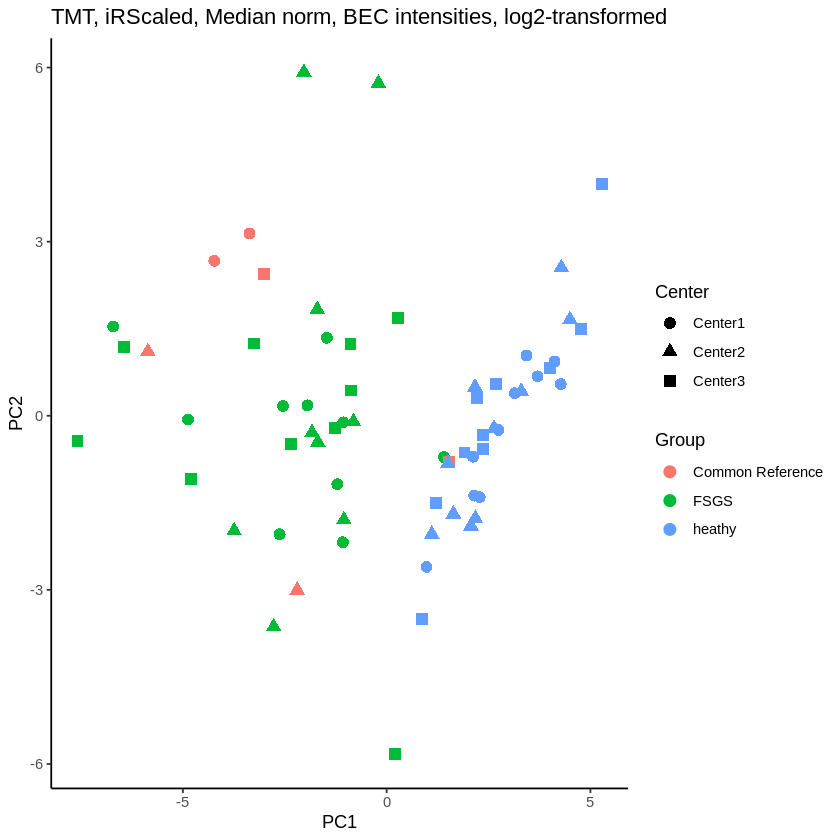

In [ ]:

  pca <- prcomp(t(na.omit(corrected_sl_irs)))
  pca_df <- pca$x %>%
    as.data.frame() %>%
    rownames_to_column("Quantitative.column.name") %>% 
    left_join(metadata,  by = "Quantitative.column.name") 
  var_expl <- pca$sdev^2 / sum(pca$sdev^2)
  names(var_expl) <- paste0("PC", 1:length(var_expl))

  pca_df %>%
    ggplot(aes(PC1, PC2)) +
    geom_point(aes(col=Group, shape=Center), size=3)  +
    theme_classic() +
    labs(title = "TMT, iRScaled, Median norm, BEC intensities, log2-transformed")
  

### SL - iRS - BEC

In [ ]:
intensities_sl <- sample_load_norm(pg_intensities, metadata)

dim(intensities_sl)
round(sum(is.na(intensities_sl)) * 100 / (dim(intensities_sl)[1] * dim(intensities_sl)[2]), 3)

plot_three_in_one(log2(intensities_scaled + 1),
                  metadata,
                  "TMT, SL-norm protein intensities, log2-transformed",
                  "/home/yuliya/repos/cosybio/FedProt/data/TMT_data/balanced_data/combined_plots/02_pg_intensities_scaled_log")
                  

[1] 660  65

[1] 22.245

Saving 6.67 x 6.67 in image
Warning message:
“Removed 9543 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 9543 rows containing non-finite values (`stat_summary()`).”
Warning message:
“Removed 9543 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 9543 rows containing non-finite values (`stat_summary()`).”
Warning message:
“Graphs cannot be vertically aligned unless the axis parameter is set. Placing graphs unaligned.”


In [ ]:
intensities_sl %>%
    # summarize(across(everything(), ~sum(., na.rm = TRUE))) %>%
    pivot_longer(cols = everything(), 
                 names_to = "Quantitative.column.name", 
                 values_to = "Value") %>%
    na.omit() %>%
    left_join(select(metadata, c(Quantitative.column.name, Pool, Center)), by = 'Quantitative.column.name') %>%
    group_by(Center, Pool, Quantitative.column.name) %>%
    summarize(sum = sum(Value, na.rm = TRUE), mean = mean(Value, na.rm = TRUE)) %>%
    group_by(Center, Pool) %>%
    summarise(mean_sample_sum = mean(sum), mean_sample_mean = mean(mean))

`summarise()` has grouped output by 'Center', 'Pool'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'Center'. You can override using the
`.groups` argument.


Center,Pool,mean_sample_sum,mean_sample_mean
<fct>,<chr>,<dbl>,<dbl>
Center1,Pool1,965897328,1765809
Center1,Pool2,965897328,1879178
Center2,Pool3,965897328,1854643
Center2,Pool5,965897328,1691589
Center3,Pool4,965897328,2192969
Center3,Pool6,965897328,1985228


In [ ]:
intensities_scaled <- iRS_function(intensities_sl, metadata)

dim(intensities_scaled)
round(sum(is.na(intensities_scaled)) * 100 / (dim(intensities_scaled)[1] * dim(intensities_scaled)[2]), 3)

plot_three_in_one(log2(intensities_scaled + 1),
                  metadata,
                  "TMT, SL, iRS-scaled protein intensities, log2-transformed",
                  "/home/yuliya/repos/cosybio/FedProt/data/TMT_data/balanced_data/combined_plots/03_pg_intensities_SL_scaled_log")
                  

[1] 660  65

[1] 22.245

Saving 6.67 x 6.67 in image
Warning message:
“Removed 9543 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 9543 rows containing non-finite values (`stat_summary()`).”
Warning message:
“Removed 9543 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 9543 rows containing non-finite values (`stat_summary()`).”
Warning message:
“Graphs cannot be vertically aligned unless the axis parameter is set. Placing graphs unaligned.”


In [ ]:
intensities_scaled %>%
    # summarize(across(everything(), ~sum(., na.rm = TRUE))) %>%
    pivot_longer(cols = everything(), 
                 names_to = "Quantitative.column.name", 
                 values_to = "Value") %>%
    na.omit() %>%
    left_join(select(metadata, c(Quantitative.column.name, Pool, Center)), by = 'Quantitative.column.name') %>%
    group_by(Center, Pool, Quantitative.column.name) %>%
    summarize(sum = sum(Value, na.rm = TRUE), mean = mean(Value, na.rm = TRUE)) %>%
    group_by(Center, Pool) %>%
    summarise(mean_sample_sum = mean(sum), mean_sample_mean = mean(mean))

`summarise()` has grouped output by 'Center', 'Pool'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'Center'. You can override using the
`.groups` argument.


Center,Pool,mean_sample_sum,mean_sample_mean
<fct>,<chr>,<dbl>,<dbl>
Center1,Pool1,967948245,1769558
Center1,Pool2,966982277,1881288
Center2,Pool3,968599906,1859831
Center2,Pool5,965190890,1690352
Center3,Pool4,963626122,2187756
Center3,Pool6,969858563,1993371


In [ ]:
# bacth effects correction

design <- model.matrix(~0 + metadata$Group)
corrected_sl_irs <- limma::removeBatchEffect(log2(intensities_scaled + 1), 
    batch2 = metadata$Pool, 
    design = design)



dim(corrected_sl_irs)
round(sum(is.na(corrected_sl_irs)) * 100 / (dim(corrected_sl_irs)[1] * dim(corrected_sl_irs)[2]), 3)

plot_three_in_one(as.data.frame(corrected_sl_irs),
                  metadata,
                  "TMT, SL, iRScaled, BEC intensities, log2-transformed",
                  "/home/yuliya/repos/cosybio/FedProt/data/TMT_data/balanced_data/combined_plots/04_pg_intensities_SL_scaled_log_BEC")

Warning message:
“Partial NA coefficients for 296 probe(s)”


[1] 660  65

[1] 22.245

Saving 6.67 x 6.67 in image
Warning message:
“Removed 9543 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 9543 rows containing non-finite values (`stat_summary()`).”
Warning message:
“Removed 9543 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 9543 rows containing non-finite values (`stat_summary()`).”
Warning message:
“Graphs cannot be vertically aligned unless the axis parameter is set. Placing graphs unaligned.”


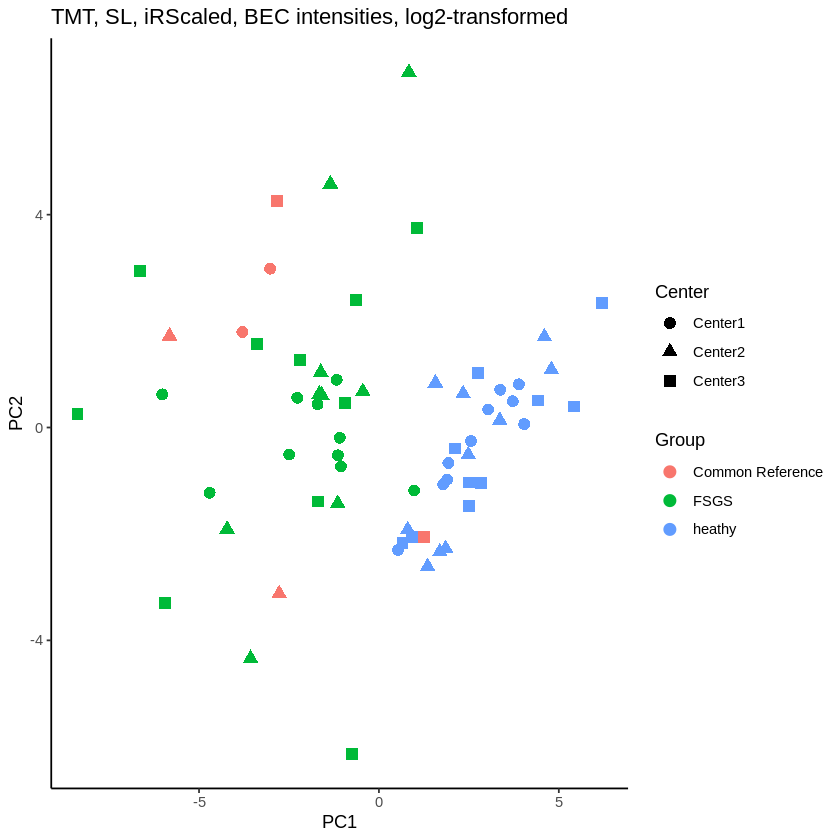

In [ ]:

  pca <- prcomp(t(na.omit(corrected_sl_irs)))
  pca_df <- pca$x %>%
    as.data.frame() %>%
    rownames_to_column("Quantitative.column.name") %>% 
    left_join(metadata,  by = "Quantitative.column.name") 
  var_expl <- pca$sdev^2 / sum(pca$sdev^2)
  names(var_expl) <- paste0("PC", 1:length(var_expl))

  pca_df %>%
    ggplot(aes(PC1, PC2)) +
    geom_point(aes(col=Group, shape=Center), size=3)  +
    theme_classic() +
    labs(title = "TMT, SL, iRScaled, BEC intensities, log2-transformed")
  

# Merge three separate MaxQuant runs

In [23]:
metadata <- read.table("/home/yuliya/repos/cosybio/FedProt/data/TMT_data/raw_MaxQuant_reports/Metadata_CosyBio.tsv",
                       header = TRUE, sep = "\t", stringsAsFactors = FALSE)
                       
metadata <- metadata %>%
            mutate(Quantitative.column.name = gsub(" ", ".", Quantitative.column.name))

rownames(metadata) <- metadata$Quantitative.column.name
metadata <- metadata %>%
            mutate(Quantitative.column.name = gsub(".Pool", ".P_", gsub("Reporter.intensity.corrected.", "RIC_", Quantitative.column.name)))


# remove the outlier
metadata <- metadata %>%
            filter(Quantitative.column.name != "RIC_3.P_3")


# rename the columns - put the .P_[1-9]+ after dot before and the rest after (e.g. RIC_1.P_1 -> P_1.RIC_1)
metadata <- metadata %>%
            mutate(Quantitative.column.name = gsub("RIC_([0-9]+).P_([0-9]+)", "P_\\2.RIC_\\1", Quantitative.column.name))


head(metadata, 3)
dim(metadata)

,Quantitative.column.name,Pool,Reporter.ion,Patient,Group,Center
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Reporter.intensity.corrected.1.Pool1,P_1.RIC_1,Pool1,126,Common Reference,Common Reference,Center1
Reporter.intensity.corrected.2.Pool1,P_1.RIC_2,Pool1,127N,heathy1,heathy,Center1
Reporter.intensity.corrected.3.Pool1,P_1.RIC_3,Pool1,127C,FSGS1,FSGS,Center1


[1] 65  6

In [39]:
preprocess_mxout <- function(path, center_metadata, center){
    PG_report <- read.table(
        path,
        header=T,
        sep="\t",
        stringsAsFactors = F)
    
    # remove decoy matches and matches to contaminant
    PG_report <- PG_report[!PG_report$Reverse=="+",]
    PG_report <- PG_report[!PG_report$Potential.contaminant=="+",]
    # if the PG_report$Only.identified.by.site is not all NA and contains "+" values - remove this rows
    if(!all(is.na(PG_report$Only.identified.by.site))) {
        # # Only.identified.by.site - exclude proteins that were only identified by a modification site
        PG_report <- PG_report[!PG_report$Only.identified.by.site=="+",]
    }

    print(center)
    print(length(PG_report$Protein.IDs))
    # take only the columns that we need
    pg_intensities <- PG_report %>%
        select(c("Protein.IDs", "Gene.names", rownames(center_metadata))) %>%
        rename(Protein.IDs = Protein.IDs)

    print(length(pg_intensities$Protein.IDs))

    # counts
    pg_counts <- PG_report %>%
        select(c("Protein.IDs", "Razor...unique.peptides")) 
    rownames(pg_counts) <- pg_counts$Protein.IDs
    pg_counts$Protein.IDs <- NULL
    pg_counts <- pg_counts + 1

    return(list(pg_intensities, pg_counts))    

}

In [40]:
list_of_outputs <- list(
    "Center1" = "/home/yuliya/repos/cosybio/FedProt/data/TMT_data/raw_MaxQuant_reports/proteinGroups_center1.txt",
    "Center2" = "/home/yuliya/repos/cosybio/FedProt/data/TMT_data/raw_MaxQuant_reports/proteinGroups_center2.txt",
    "Center3" = "/home/yuliya/repos/cosybio/FedProt/data/TMT_data/raw_MaxQuant_reports/proteinGroups_center3.txt"
)

combined_pg_intensities <- data.frame()

for(center in names(list_of_outputs)) {

    center_metadata <- metadata %>%
        filter(Center == center)

    center_folder <- ifelse(center == "Center1", "center_one", ifelse(center == "Center2", "center_two", "center_three"))
    results_list <- preprocess_mxout(list_of_outputs[[center]], center_metadata, center)
    pg_intensities <- results_list[[1]]
    counts_df <- results_list[[2]]

    pg_intensities <- pg_intensities[, c("Protein.IDs", "Gene.names", rownames(center_metadata))]
    colnames(pg_intensities) <- c("Protein.IDs", "Gene.names", center_metadata$Quantitative.column.name)
    pg_intensities %>% write.table(paste0("/home/yuliya/repos/cosybio/FedProt/data/TMT_data/balanced_data/", center_folder, "/pg_intensities.tsv"),
                                   sep = "\t", quote = FALSE, row.names = FALSE)

    counts_df %>% write.table(paste0("/home/yuliya/repos/cosybio/FedProt/data/TMT_data/balanced_data/", center_folder, "/pg_counts.tsv"),
                                      sep = "\t", quote = FALSE, row.names = TRUE)


    write.table(metadata[metadata$Center == center,], 
                paste0("/home/yuliya/repos/cosybio/FedProt/data/TMT_data/balanced_data/", center_folder, "/metadata.tsv"),
                sep = "\t", quote = FALSE, row.names = FALSE)


    if(!(nrow(combined_pg_intensities) == 0)) {
        combined_pg_intensities <- full_join(combined_pg_intensities, pg_intensities, by = c("Protein.IDs", "Gene.names"))
    } else {
        combined_pg_intensities <- pg_intensities
    }
}


dim(combined_pg_intensities)

# rownames(combined_pg_intensities) <- combined_pg_intensities$Protein.IDs
# combined_pg_intensities$Protein.IDs <- NULL

# order the columns
combined_pg_intensities <- combined_pg_intensities[, c("Protein.IDs", "Gene.names", metadata$Quantitative.column.name)]
# combined_pg_intensities <- combined_pg_intensities[!rowSums(combined_pg_intensities, na.rm = TRUE) == 0,]
# combined_pg_intensities[combined_pg_intensities==0] <- NA
# remove rows with all values are NA
# combined_pg_intensities <- combined_pg_intensities[!rowSums(!is.na(combined_pg_intensities)) == 0,]

# write merged data
combined_pg_intensities %>% write.table("/home/yuliya/repos/cosybio/FedProt/data/TMT_data/balanced_data/combined/combined_pg_intensities.tsv",
                               sep = "\t", quote = FALSE, row.names = FALSE)

dim(combined_pg_intensities)
dim(na.omit(combined_pg_intensities))
head(combined_pg_intensities, 5)




[1] "Center1"
[1] 500
[1] 500
[1] "Center2"
[1] 530
[1] 530
[1] "Center3"
[1] 456
[1] 456


[1] 871  67

[1] 871  67

[1] 228  67

,Protein.IDs,Gene.names,P_1.RIC_1,P_1.RIC_2,P_1.RIC_3,P_1.RIC_4,P_1.RIC_5,P_1.RIC_6,P_1.RIC_7,P_1.RIC_8,⋯,P_6.RIC_2,P_6.RIC_3,P_6.RIC_4,P_6.RIC_5,P_6.RIC_6,P_6.RIC_7,P_6.RIC_8,P_6.RIC_9,P_6.RIC_10,P_6.RIC_11
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,A0A024R6N5;A0A0G2JRN3;G3V2B9;G3V544;G3V5R8;G3V387;A0A0B4J278;P20848,,1472900.0,1120700,1128900,866950.0,1190000.0,934530,1217200.0,999950,⋯,82668,75290,77846,84484,91495,103070,176440,1544200,92816,87081
2,A0A075B6I0,IGLV8-61,5056.4,19023,10474,6561.4,6814.2,7566,6963.3,17172,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,A0A075B6I9;P04211,IGLV7-46,7923.6,22406,14546,18154.0,10296.0,14781,9538.2,24929,⋯,83664,125190,65350,80610,75906,76086,87507,73270,109490,80759
4,A0A075B6K4;P01715,IGLV3-10,9883.0,18581,16772,11245.0,20072.0,15921,11321.0,18452,⋯,103080,130410,122660,90457,76299,91018,114080,124650,197430,118260
5,A0A075B6P5;A0A087WW87;P01615;P01614;A2NJV5;A0A0A0MRZ7;A0A075B6S6;A0A075B6S2;P06310,IGKV2D-28;IGKV2-40;IGKV A18;IGKV2D-26;IGKV2D-30;IGKV2D-29,38038.0,74443,38679,43767.0,40436.0,40480,42700.0,51910,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [36]:
combined_pg_intensities %>%
    filter(str_detect(Protein.IDs, "Q92954"))

Protein.IDs,Gene.names,P_1.RIC_1,P_1.RIC_2,P_1.RIC_3,P_1.RIC_4,P_1.RIC_5,P_1.RIC_6,P_1.RIC_7,P_1.RIC_8,⋯,P_6.RIC_2,P_6.RIC_3,P_6.RIC_4,P_6.RIC_5,P_6.RIC_6,P_6.RIC_7,P_6.RIC_8,P_6.RIC_9,P_6.RIC_10,P_6.RIC_11
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Q92954,PRG4,402200,269880,336590,289450,469030,284130,400010,207440,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Q92954;E9PLR3,PRG4,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Q92954;J3KP74;E9PLR3,PRG4,NA,NA,NA,NA,NA,NA,NA,NA,⋯,3637100,2530500,4078300,4709300,3231900,3917500,3063200,3768100,3268600,2817200


In [78]:
rownames(metadata) <- metadata$Quantitative.column.name
metadata <- metadata %>%
    mutate(Group = as.factor(Group), Center = as.factor(Center), Reporter.ion = as.factor(Reporter.ion)) %>%
    mutate(Quantitative.column.name = gsub(" ", ".", Quantitative.column.name))

In [79]:
plot_three_in_one(log2(combined_pg_intensities + 1),
                  metadata,
                  "TMT-data, Combined, raw protein intensities, log2-transformed", # nolint: line_length_linter.
                  "/home/yuliya/repos/cosybio/FedProt/data/TMT_data/balanced_data/combined/plots/01_pg_intensities_raw_log")
                  

Saving 6.67 x 6.67 in image
Warning message:
“Removed 25424 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 25424 rows containing non-finite values (`stat_summary()`).”
Warning message:
“Removed 25424 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 25424 rows containing non-finite values (`stat_summary()`).”
Warning message:
“Graphs cannot be vertically aligned unless the axis parameter is set. Placing graphs unaligned.”


In [80]:
# print(format(round(colSums(pg_intensities, na.rm = TRUE), digits = 0), big.mark = ","))

# the same using tidyverse and summarize function
combined_pg_intensities %>%
    # summarize(across(everything(), ~sum(., na.rm = TRUE))) %>%
    pivot_longer(cols = everything(), 
                 names_to = "Quantitative.column.name", 
                 values_to = "Value") %>%
    na.omit() %>%
    left_join(select(metadata, c(Quantitative.column.name, Pool, Center)), by = 'Quantitative.column.name') %>%
    group_by(Center, Pool, Quantitative.column.name) %>%
    summarize(sum = sum(Value, na.rm = TRUE), mean = mean(Value, na.rm = TRUE)) %>%
    group_by(Center, Pool) %>%
    summarise(mean_sample_sum = mean(sum), mean_sample_mean = mean(mean))

`summarise()` has grouped output by 'Center', 'Pool'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'Center'. You can override using the
`.groups` argument.


Center,Pool,mean_sample_sum,mean_sample_mean
<fct>,<chr>,<dbl>,<dbl>
Center1,Pool1,161241703,332520.3
Center1,Pool2,149341133,315065.7
Center2,Pool3,407628918,867295.6
Center2,Pool5,384075724,757545.8
Center3,Pool4,2038351249,5077746.8
Center3,Pool6,2619711157,6195940.8


In [81]:
dim(na.omit(combined_pg_intensities))

[1] 200  65

### iRS - median  - BEC

In [82]:
intensities_scaled <- iRS_function(combined_pg_intensities, metadata)

dim(intensities_scaled)
round(sum(is.na(intensities_scaled)) * 100 / (dim(intensities_scaled)[1] * dim(intensities_scaled)[2]), 3)

plot_three_in_one(log2(intensities_scaled + 1),
                  metadata,
                  "TMT, Combined, iRS-scaled protein intensities, log2-transformed",
                  "/home/yuliya/repos/cosybio/FedProt/data/TMT_data/balanced_data/combined/plots/02_pg_intensities_irs_log")
                  

[1] 851  65

[1] 45.962

Saving 6.67 x 6.67 in image
Warning message:
“Removed 25424 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 25424 rows containing non-finite values (`stat_summary()`).”
Warning message:
“Removed 25424 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 25424 rows containing non-finite values (`stat_summary()`).”
Warning message:
“Graphs cannot be vertically aligned unless the axis parameter is set. Placing graphs unaligned.”


In [83]:
intensities_scaled_norm <- median_noramlization(intensities_scaled, log_normalized = FALSE)

dim(intensities_scaled_norm)
round(sum(is.na(intensities_scaled_norm)) * 100 / (dim(intensities_scaled_norm)[1] * dim(intensities_scaled_norm)[2]), 3)

plot_three_in_one(intensities_scaled_norm,
                  metadata,
                  "TMT, Combined, iRScaled, Median norm intensities, log2-transformed",
                  "/home/yuliya/repos/cosybio/FedProt/data/TMT_data/balanced_data/combined/plots/03_pg_intensities_irs_median_log")

[1] 851  65

[1] 45.962

Saving 6.67 x 6.67 in image
Warning message:
“Removed 25424 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 25424 rows containing non-finite values (`stat_summary()`).”
Warning message:
“Removed 25424 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 25424 rows containing non-finite values (`stat_summary()`).”
Warning message:
“Graphs cannot be vertically aligned unless the axis parameter is set. Placing graphs unaligned.”


In [84]:
# bacth effects correction

design <- model.matrix(~0 + metadata$Group)
corrected_irs <- limma::removeBatchEffect(intensities_scaled_norm, 
    batch2 = metadata$Pool, 
    design = design)



dim(corrected_irs)
round(sum(is.na(corrected_irs)) * 100 / (dim(corrected_irs)[1] * dim(corrected_irs)[2]), 3)

plot_three_in_one(as.data.frame(corrected_irs),
                  metadata,
                  "TMT, Combined, iRScaled, Median norm, BEC intensities, log2-transformed",
                   "/home/yuliya/repos/cosybio/FedProt/data/TMT_data/balanced_data/combined/plots/04_pg_intensities_irs_median_log_BEC")

Warning message:
“Partial NA coefficients for 647 probe(s)”


[1] 851  65

[1] 45.962

Saving 6.67 x 6.67 in image
Warning message:
“Removed 25424 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 25424 rows containing non-finite values (`stat_summary()`).”
Warning message:
“Removed 25424 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 25424 rows containing non-finite values (`stat_summary()`).”
Warning message:
“Graphs cannot be vertically aligned unless the axis parameter is set. Placing graphs unaligned.”
